In [7]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.utils import class_weight, resample
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTENC

data = pd.read_csv("../data/data_imputed.csv")
#drop values where other_cancer is equal to don't know
data = data[data.other_cancer != "Don't know / Not Sure / Refused / Missing"]

#get index of categorical features
cat_cols = data.select_dtypes(include='object').columns
cat_cols_idx = [col in cat_cols for col in data.columns]

label_encoders = {}
for column in data.columns:
    if data[column].dtype == 'object':
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le
del column, label_encoders, le

target = 'other_cancer'
X = data.drop(target, axis=1)  # Features (all columns except the target)
y = data[target]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
def decision_tree(X_train, X_test, y_train, y_test, class_weight=None):
    if class_weight is None:
        clf = DecisionTreeClassifier()
    else:
        clf = DecisionTreeClassifier(class_weight=class_weight)
    # Train the model
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    model_results(y_pred, y_test, y_pred_proba)


def random_forest(X_train, X_test, y_train, y_test, class_weight=None):
    if class_weight is None:
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
    else:
        clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight)

    # Train the model
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # Make predictions
    y_pred = clf.predict(X_test)

    model_results(y_pred, y_test, y_pred_proba)
        
def model_results(y_pred, y_test, y_pred_proba):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    #calculate f1 score
    f1 = f1_score(y_test, y_pred, average='macro')
    print("F1 score:", f1)

    report = classification_report(y_test, y_pred)
    print(report)

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print('ROC AUC score:', roc_auc)

In [9]:
print("Decision Tree without class weighting")
decision_tree(X_train, X_test, y_train, y_test)

print("\nRandom Forest without class weighting")
random_forest(X_train, X_test, y_train, y_test)


Decision Tree without class weighting
Accuracy: 0.80
F1 score: 0.5596784587473759
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     61847
           1       0.22      0.25      0.23      8432

    accuracy                           0.80     70279
   macro avg       0.56      0.56      0.56     70279
weighted avg       0.81      0.80      0.81     70279

Confusion Matrix:
[[54326  7521]
 [ 6334  2098]]
ROC AUC score: 0.5636037482808236
Random Forest without class weighting
Accuracy: 0.88
F1 score: 0.5033031162687468
              precision    recall  f1-score   support

           0       0.88      0.99      0.94     61847
           1       0.50      0.04      0.07      8432

    accuracy                           0.88     70279
   macro avg       0.69      0.52      0.50     70279
weighted avg       0.84      0.88      0.83     70279

Confusion Matrix:
[[61525   322]
 [ 8111   321]]
ROC AUC score: 0.7693854960191442


In [10]:
# from sklearn.tree import export_graphviz
# import graphviz
# import pydotplus

# dot_data = export_graphviz(clf, out_file=None, feature_names=X.columns, filled=True, rounded=True, special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data)
# graph.write_png('decision_tree.png')

In [11]:
# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

print("Decision Tree with class weighting")
decision_tree(X_train, X_test, y_train, y_test, class_weights_dict)

print("\nRandom Forest without class weighting")
random_forest(X_train, X_test, y_train, y_test, class_weights_dict)

Decision Tree with class weighting
Accuracy: 0.81
F1 score: 0.5587307418602833
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     61847
           1       0.22      0.22      0.22      8432

    accuracy                           0.81     70279
   macro avg       0.56      0.56      0.56     70279
weighted avg       0.81      0.81      0.81     70279

Confusion Matrix:
[[55381  6466]
 [ 6565  1867]]
ROC AUC score: 0.5584350426078997
Random Forest without class weighting
Accuracy: 0.88
F1 score: 0.49479134663560026
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     61847
           1       0.47      0.03      0.05      8432

    accuracy                           0.88     70279
   macro avg       0.68      0.51      0.49     70279
weighted avg       0.83      0.88      0.83     70279

Confusion Matrix:
[[61575   272]
 [ 8191   241]]
ROC AUC score: 0.7693447371534377


In [12]:
# Undersample the majority class
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print("Decision Tree with Undersampling")
decision_tree(X_resampled, X_test, y_resampled, y_test)

print("\nRandom Forest with Undersampling")
random_forest(X_resampled, X_test, y_resampled, y_test)

Decision Tree with Undersampling
Accuracy: 0.62
F1 score: 0.5123247517462421
              precision    recall  f1-score   support

           0       0.92      0.62      0.74     61847
           1       0.18      0.62      0.28      8432

    accuracy                           0.62     70279
   macro avg       0.55      0.62      0.51     70279
weighted avg       0.83      0.62      0.69     70279

Confusion Matrix:
[[38395 23452]
 [ 3193  5239]]
ROC AUC score: 0.6210648562058743
Random Forest with Undersampling
Accuracy: 0.67
F1 score: 0.5658549349885693
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     61847
           1       0.23      0.76      0.35      8432

    accuracy                           0.67     70279
   macro avg       0.59      0.71      0.57     70279
weighted avg       0.87      0.67      0.73     70279

Confusion Matrix:
[[40593 21254]
 [ 2034  6398]]
ROC AUC score: 0.7756141105342623


In [13]:
# Oversample the minority class
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print("Decision Tree with Oversampling")
decision_tree(X_resampled, X_test, y_resampled, y_test)

print("\nRandom Forest with Oversampling")
random_forest(X_resampled, X_test, y_resampled, y_test)

Decision Tree with Oversampling
Accuracy: 0.81
F1 score: 0.5582714158282643
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     61847
           1       0.22      0.22      0.22      8432

    accuracy                           0.81     70279
   macro avg       0.56      0.56      0.56     70279
weighted avg       0.81      0.81      0.81     70279

Confusion Matrix:
[[55248  6599]
 [ 6547  1885]]
ROC AUC score: 0.5584289782992363
Random Forest with Oversampling
Accuracy: 0.87
F1 score: 0.5557918892105246
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     61847
           1       0.40      0.12      0.18      8432

    accuracy                           0.87     70279
   macro avg       0.65      0.55      0.56     70279
weighted avg       0.83      0.87      0.84     70279

Confusion Matrix:
[[60395  1452]
 [ 7453   979]]
ROC AUC score: 0.7707791422236835


In [14]:
# Downsample majority class to 50000 samples
majority_downsampled = resample(data[data[target]==0],
                                replace=False, # sample without replacement
                                n_samples=50000, # number of samples to downsample to
                                random_state=42) # reproducible results

# Combine minority class and downsampled majority class
downsampled_data = pd.concat([majority_downsampled, data[data[target]==1]])

# Shuffle the data
downsampled_data = downsampled_data.sample(frac=1, random_state=42)

X = downsampled_data.drop(target, axis=1)  # Features (all columns except the target)
y = downsampled_data[target]  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTENC(random_state=42, categorical_features = cat_cols_idx)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Decision Tree with SMOTENC")
decision_tree(X_resampled, X_test, y_resampled, y_test)

print("\nRandom Forest with SMOTENC")
random_forest(X_resampled, X_test, y_resampled, y_test)

state: 0.11017804727396656
health_insurance: 0.03472583100468897
personal_physician: 0.016615026082836062
doctor_visit_ability: 0.005421227053224356
last_visit: 0.014848626342087307
stroke: 0.007988657004579455
skin_cancer: 0.03943893094234452
copd: 0.00969601991720879
depression: 0.014320201045437499
kidney_disease: 0.009035855800425357
diabetes: 0.017466952858901087
employment: 0.030290806272862153
pneumonia_shot: 0.02431106310353543
hiv_risk: 0.0038406395251105127
metropolitan_status: 0.016694878682958735
health_status: 0.03707662549990889
physical activity: 0.014372370756950869
chd: 0.009416479828395911
asthma: 0.015653362774675193
arthritis: 0.0156412645322993
race: 0.014398167271190362
sex: 0.015697545461558545
colonoscopy: 0.012304192354700835
sigmoidoscopy: 0.011590313705083793
age: 0.18495981681251836
bmi: 0.1458221227139635
education: 0.032522407423141025
income: 0.05139759798969268
smoking: 0.02583485919380548
drinks_consumed_last_30_days: 0.05844011077194856


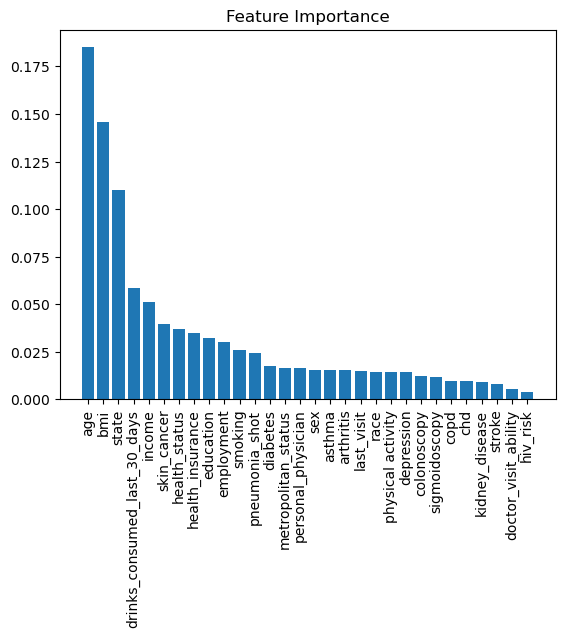

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# Get feature importances
importances = clf.feature_importances_

# Print the name and importance of each feature 
for feature_name, importance in zip(X.columns, importances):
    print(f"{feature_name}: {importance}")
#sort features by importance
sorted(zip(importances, X.columns), reverse=True)

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()


In [ ]:
#USE F1 MACRO INSTEAD OF ACCURACY
#RECALL
#ROC AND AOC
#more false positives than false negatives
#more sensitivisity than specificity instead of false positives/negatives


In [ ]:
#consider converting numerical to categorical via bins
#random forest feature selection
#one hot encoding
#frequency encoding
#chi square
#try dividing data set by age
